- coisas para add 
    - data augmentation
    - matriz de confusao 
    - acuracia ao longo do tempo 
    - nova ativacao(leaky relu) 
    - tamanho dos modelos e arquiteura final 

# Imports

In [9]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

import optuna 

import numpy as np

from tqdm import tqdm

import matplotlib.pyplot as plt

from sklearn import metrics

# Helper functions and MLP class

In [7]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_layers, num_classes, activation_function, dropout_rate, use_batch_norm=True):
        super(MLP, self).__init__()
        self.activation_function = activation_function
        self.dropout = nn.Dropout(p=dropout_rate)
        self.use_batch_norm = use_batch_norm

        layers_dims = [input_size] + hidden_layers + [num_classes]
        self.layers = nn.ModuleList()
        self.batch_norms = nn.ModuleList()

        for i in range(len(layers_dims) - 1):  
            self.layers.append(nn.Linear(layers_dims[i], layers_dims[i+1]))
            
            if use_batch_norm and i < len(layers_dims) - 2:
                self.batch_norms.append(nn.BatchNorm1d(layers_dims[i+1]))



    def forward(self, x):
        for layer in self.layers[:-1]:
            x = self.activation_function(layer(x))
            x = self.dropout(x)

        x = self.layers[-1](x)
        
        return x 

In [8]:
def get_scores(targets, predictions):
    return {
        "accuracy"         : metrics.accuracy_score(targets, predictions),
        "balanced_accuracy": metrics.balanced_accuracy_score(targets, predictions),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted"),
        "precision"        : metrics.precision_score(targets, predictions, average="weighted"),
        "recall"           : metrics.recall_score(targets, predictions, average="weighted"),
        "f1_score"         : metrics.f1_score(targets, predictions, average="weighted")
    }

def evaluate_model(model, data_loader, loss_function):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in data_loader:
            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            total_loss += loss.item()

    return total_loss / len(data_loader)

def show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val):
    plt.plot(arr_losses_train, label = "train loss")
    plt.plot(arr_losses_val, label = "val loss")
    plt.plot(arr_losses_test, label = "test loss")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.grid()
    plt.legend()
    return None

def show_predictions(model, dataloader, num_samples):
    model.eval()
    correct_samples = []
    wrong_samples = []

    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']
    
    with torch.no_grad():
        for images, labels in dataloader:
            original_images = images

            images = images.view(-1, 32*32*3).cuda()
            labels = labels.cuda()

            outputs = model.forward(images)
            _, predicted = torch.max(outputs.data, 1)

            for i in range(len(labels)):
                pred = predicted[i].cpu().item()
                true = labels[i].cpu().item()
                img = original_images[i]

                if pred == true and len(correct_samples) < num_samples:
                    correct_samples.append((img, pred, true))
                elif pred != true and len(wrong_samples) < num_samples:
                    wrong_samples.append((img, pred, true))

                if len(correct_samples) >= num_samples and len(wrong_samples) >= num_samples:
                    break

    plt.figure(figsize=(24, 20))
    
    plt.subplot(1, 2, 1)
    # acertos
    for idx, (img, pred, true) in enumerate(correct_samples):
        plt.subplot(2, num_samples, idx + 1)
        img = img.permute(1, 2, 0)  
        img = img * 0.5 + 0.5 
        plt.imshow(img)
        plt.title(f'Correto!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')

    # erros
    for idx, (img, pred, true) in enumerate(wrong_samples):
        plt.subplot(2, num_samples, idx + num_samples + 1)
        img = img.permute(1, 2, 0)
        img = img * 0.5 + 0.5
        plt.imshow(img)
        plt.title(f'Erro!\nPred: {classes[pred]}\nTrue: {classes[true]}')
        plt.axis('off')
    
    plt.tight_layout(h_pad=2)
    plt.show()

    return None

def objective(trial):
    global train_dataset_global, validation_dataset_global

    activation_name = trial.suggest_categorical('activation', ['ReLU', 'Sigmoid', 'Tanh'])
    activation_functions = {
        'ReLU': nn.ReLU(),
        'Sigmoid': nn.Sigmoid(),
        'Tanh': nn.Tanh()
    }
    activation_function = activation_functions[activation_name]
    learning_rate = trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
    batch_size = trial.suggest_int('batch_size', 32, 512)

    # reg params
    dropout_rate = trial.suggest_float('dropout_rate', 0.0, 0.5)
    weight_decay = trial.suggest_float('weight_decay', 1e-5, 1e-2, log=True)
    use_batch_norm = trial.suggest_categorical('use_batch_norm', [True, False])

    n_layers = trial.suggest_int('n_layers', 2, 7)
    hidden_layers = []
    for i in range(n_layers):
        n_units = trial.suggest_int(f'n_units_l{i}', 32, 256)
        hidden_layers.append(n_units)

    input_size = 32*32*3
    num_classes = 10
    loss_function = nn.CrossEntropyLoss()
    
    train_loader = torch.utils.data.DataLoader(
        dataset=train_dataset_global, 
        batch_size=batch_size, 
        shuffle=True
    )
    val_loader = torch.utils.data.DataLoader(
        dataset=validation_dataset_global, 
        batch_size=batch_size, 
        shuffle=False
    )

    model = MLP(
        input_size=input_size,
        hidden_layers=hidden_layers,
        num_classes=num_classes,
        activation_function=activation_function,
        dropout_rate=dropout_rate,
        use_batch_norm=use_batch_norm
    ).cuda()
    
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    
    for _ in range(50):
        model.train()
        for images, labels in train_loader:
            images = images.view(-1, input_size).cuda()
            labels = labels.cuda()
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_function(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval() # disable dropout just to validate
        val_loss = evaluate_model(model, val_loader, loss_function)
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    return best_val_loss


# Setup

In [2]:
transform_train = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.RandomCrop(32, padding=4),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # ImageNet stats funciona melhor
])

# Transformação apenas para validação e teste (sem augmentation)
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size

train_dataset, validation_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

validation_dataset.dataset.transform = transform_test

In [3]:
# just to run fast
subset_sample      = 1000

train_dataset      = torch.utils.data.Subset(train_dataset, range(subset_sample))
validation_dataset = torch.utils.data.Subset(validation_dataset, range(subset_sample))
test_dataset       = torch.utils.data.Subset(test_dataset, range(subset_sample))


In [4]:
train_dataset_global = train_dataset
validation_dataset_global = validation_dataset

# Def hyperparameters and Loaders

In [5]:
loss_function       = nn.CrossEntropyLoss()

# Main training Loop

## Optuna optimization

In [10]:
n_trials=2
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=n_trials)

[I 2025-06-14 20:42:11,792] A new study created in memory with name: no-name-34dfab40-5c46-41f9-9ba3-7334cba88893
[I 2025-06-14 20:42:18,183] Trial 0 finished with value: 2.2750085592269897 and parameters: {'activation': 'Tanh', 'learning_rate': 1.3918115565935064e-05, 'batch_size': 275, 'dropout_rate': 0.477602840871821, 'weight_decay': 0.0001722646828950294, 'use_batch_norm': False, 'n_layers': 7, 'n_units_l0': 232, 'n_units_l1': 157, 'n_units_l2': 185, 'n_units_l3': 156, 'n_units_l4': 170, 'n_units_l5': 192, 'n_units_l6': 235}. Best is trial 0 with value: 2.2750085592269897.
[I 2025-06-14 20:42:24,204] Trial 1 finished with value: 2.275806506474813 and parameters: {'activation': 'ReLU', 'learning_rate': 1.3876618592080614e-05, 'batch_size': 489, 'dropout_rate': 0.22120688541926387, 'weight_decay': 0.002283471833501616, 'use_batch_norm': True, 'n_layers': 4, 'n_units_l0': 249, 'n_units_l1': 198, 'n_units_l2': 243, 'n_units_l3': 55}. Best is trial 0 with value: 2.2750085592269897.


## Best founded model

In [11]:
study.best_params

{'activation': 'Tanh',
 'learning_rate': 1.3918115565935064e-05,
 'batch_size': 275,
 'dropout_rate': 0.477602840871821,
 'weight_decay': 0.0001722646828950294,
 'use_batch_norm': False,
 'n_layers': 7,
 'n_units_l0': 232,
 'n_units_l1': 157,
 'n_units_l2': 185,
 'n_units_l3': 156,
 'n_units_l4': 170,
 'n_units_l5': 192,
 'n_units_l6': 235}

In [12]:
hidden_layers = [study.best_params[f'n_units_l{i}'] for i in range(study.best_params['n_layers'])]

activation_functions = {
    'ReLU': nn.ReLU(),
    'Sigmoid': nn.Sigmoid(),
    'Tanh': nn.Tanh()
}

best_activation = activation_functions[study.best_params['activation']]

# reg params
dropout_rate=study.best_params['dropout_rate']
use_batch_norm=study.best_params['use_batch_norm']

train_loader = torch.utils.data.DataLoader(
    dataset=train_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    dataset=validation_dataset_global, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)

test_loader = torch.utils.data.DataLoader(
    dataset=test_dataset, 
    batch_size=study.best_params['batch_size'], 
    shuffle=False
)


In [13]:
mlp = MLP(
    input_size=32*32*3,
    hidden_layers=hidden_layers,
    num_classes=10,
    activation_function=best_activation,
    dropout_rate=dropout_rate,
    use_batch_norm=use_batch_norm
)
# mlp.cpu()
mlp.cuda()

optimizer = torch.optim.Adam(mlp.parameters(), 
                             lr=study.best_params['learning_rate'], 
                             weight_decay=study.best_params['weight_decay'])

best_val_loss = float('inf')
patience = 5
patience_counter = 0

arr_losses_train = []
arr_losses_test  = []
arr_losses_val   = []

# main loop
num_epochs       = 10000
for epoch in tqdm(range(num_epochs)):
    mlp.train()
    epoch_loss = 0.0
    for i, (images, labels) in enumerate(train_loader):
        images = images.view(-1, 32*32*3).cuda()
        labels = labels.cuda()
        optimizer.zero_grad()

        # forward pass
        outputs = mlp.forward(images)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

        if (i+1) % 1000 == 0:
            tqdm.write(f' Epoch {epoch + 1}/{num_epochs}, Step {i+1}/{len(train_dataset) // study.best_params['batch_size']}, Loss: {loss}')

    mlp.eval()
    train_loss = epoch_loss/len(train_loader)
    val_loss   = evaluate_model(mlp, val_loader, loss_function)
    test_loss  = evaluate_model(mlp, test_loader, loss_function)

    arr_losses_train.append(train_loss)
    arr_losses_val.append(val_loss)
    arr_losses_test.append(test_loss)

    tqdm.write(f'Epoch {epoch+1}:')
    tqdm.write(f'Train Loss: {train_loss:.4f}')
    tqdm.write(f'Val Loss: {val_loss:.4f}')
    tqdm.write(f'Test Loss: {test_loss:.4f}')


    # early stopping 
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0

    else:
        patience_counter += 1
        if patience_counter >= patience:
            tqdm.write("early stopping based on loss reduction when we compare to val dataset")
            break

  0%|          | 2/10000 [00:00<30:57,  5.38it/s]

Epoch 1:
Train Loss: 2.3085
Val Loss: 2.3049
Test Loss: 2.3044
Epoch 2:
Train Loss: 2.3140
Val Loss: 2.3045
Test Loss: 2.3039


  0%|          | 4/10000 [00:00<30:33,  5.45it/s]

Epoch 3:
Train Loss: 2.3096
Val Loss: 2.3040
Test Loss: 2.3035
Epoch 4:
Train Loss: 2.3133
Val Loss: 2.3036
Test Loss: 2.3030


  0%|          | 6/10000 [00:01<30:43,  5.42it/s]

Epoch 5:
Train Loss: 2.3023
Val Loss: 2.3032
Test Loss: 2.3025
Epoch 6:
Train Loss: 2.3008
Val Loss: 2.3028
Test Loss: 2.3020


  0%|          | 8/10000 [00:01<30:49,  5.40it/s]

Epoch 7:
Train Loss: 2.3039
Val Loss: 2.3024
Test Loss: 2.3016
Epoch 8:
Train Loss: 2.3065
Val Loss: 2.3019
Test Loss: 2.3011


  0%|          | 10/10000 [00:01<30:56,  5.38it/s]

Epoch 9:
Train Loss: 2.3065
Val Loss: 2.3015
Test Loss: 2.3006
Epoch 10:
Train Loss: 2.3067
Val Loss: 2.3010
Test Loss: 2.3001


  0%|          | 12/10000 [00:02<30:51,  5.40it/s]

Epoch 11:
Train Loss: 2.3027
Val Loss: 2.3005
Test Loss: 2.2996
Epoch 12:
Train Loss: 2.2993
Val Loss: 2.3001
Test Loss: 2.2991


  0%|          | 14/10000 [00:02<30:56,  5.38it/s]

Epoch 13:
Train Loss: 2.3005
Val Loss: 2.2996
Test Loss: 2.2986
Epoch 14:
Train Loss: 2.2973
Val Loss: 2.2991
Test Loss: 2.2981


  0%|          | 16/10000 [00:02<30:54,  5.38it/s]

Epoch 15:
Train Loss: 2.3074
Val Loss: 2.2987
Test Loss: 2.2976
Epoch 16:
Train Loss: 2.3037
Val Loss: 2.2983
Test Loss: 2.2971


  0%|          | 18/10000 [00:03<30:39,  5.43it/s]

Epoch 17:
Train Loss: 2.3019
Val Loss: 2.2979
Test Loss: 2.2967
Epoch 18:
Train Loss: 2.3015
Val Loss: 2.2974
Test Loss: 2.2962


  0%|          | 20/10000 [00:03<31:05,  5.35it/s]

Epoch 19:
Train Loss: 2.2953
Val Loss: 2.2970
Test Loss: 2.2958
Epoch 20:
Train Loss: 2.2975
Val Loss: 2.2966
Test Loss: 2.2953


  0%|          | 22/10000 [00:04<31:07,  5.34it/s]

Epoch 21:
Train Loss: 2.2987
Val Loss: 2.2961
Test Loss: 2.2948
Epoch 22:
Train Loss: 2.3010
Val Loss: 2.2956
Test Loss: 2.2943


  0%|          | 24/10000 [00:04<31:14,  5.32it/s]

Epoch 23:
Train Loss: 2.2957
Val Loss: 2.2952
Test Loss: 2.2938
Epoch 24:
Train Loss: 2.2949
Val Loss: 2.2947
Test Loss: 2.2933


  0%|          | 26/10000 [00:04<31:03,  5.35it/s]

Epoch 25:
Train Loss: 2.2985
Val Loss: 2.2942
Test Loss: 2.2928
Epoch 26:
Train Loss: 2.2932
Val Loss: 2.2938
Test Loss: 2.2923


  0%|          | 28/10000 [00:05<30:43,  5.41it/s]

Epoch 27:
Train Loss: 2.3000
Val Loss: 2.2933
Test Loss: 2.2918
Epoch 28:
Train Loss: 2.2967
Val Loss: 2.2928
Test Loss: 2.2913


  0%|          | 30/10000 [00:05<31:00,  5.36it/s]

Epoch 29:
Train Loss: 2.2970
Val Loss: 2.2923
Test Loss: 2.2907
Epoch 30:
Train Loss: 2.2950
Val Loss: 2.2918
Test Loss: 2.2902


  0%|          | 32/10000 [00:05<31:17,  5.31it/s]

Epoch 31:
Train Loss: 2.2964
Val Loss: 2.2912
Test Loss: 2.2896
Epoch 32:
Train Loss: 2.2957
Val Loss: 2.2907
Test Loss: 2.2890


  0%|          | 34/10000 [00:06<31:08,  5.33it/s]

Epoch 33:
Train Loss: 2.2944
Val Loss: 2.2901
Test Loss: 2.2884
Epoch 34:
Train Loss: 2.2921
Val Loss: 2.2896
Test Loss: 2.2878


  0%|          | 36/10000 [00:06<30:58,  5.36it/s]

Epoch 35:
Train Loss: 2.2967
Val Loss: 2.2890
Test Loss: 2.2872
Epoch 36:
Train Loss: 2.2939
Val Loss: 2.2884
Test Loss: 2.2865


  0%|          | 38/10000 [00:07<31:19,  5.30it/s]

Epoch 37:
Train Loss: 2.2930
Val Loss: 2.2878
Test Loss: 2.2859
Epoch 38:
Train Loss: 2.2939
Val Loss: 2.2872
Test Loss: 2.2853


  0%|          | 40/10000 [00:07<31:11,  5.32it/s]

Epoch 39:
Train Loss: 2.2909
Val Loss: 2.2866
Test Loss: 2.2846
Epoch 40:
Train Loss: 2.2872
Val Loss: 2.2860
Test Loss: 2.2839


  0%|          | 42/10000 [00:07<30:59,  5.35it/s]

Epoch 41:
Train Loss: 2.2928
Val Loss: 2.2853
Test Loss: 2.2831
Epoch 42:
Train Loss: 2.2888
Val Loss: 2.2846
Test Loss: 2.2823


  0%|          | 44/10000 [00:08<30:44,  5.40it/s]

Epoch 43:
Train Loss: 2.2886
Val Loss: 2.2838
Test Loss: 2.2815
Epoch 44:
Train Loss: 2.2864
Val Loss: 2.2831
Test Loss: 2.2807


  0%|          | 46/10000 [00:08<30:40,  5.41it/s]

Epoch 45:
Train Loss: 2.2835
Val Loss: 2.2823
Test Loss: 2.2799
Epoch 46:
Train Loss: 2.2930
Val Loss: 2.2815
Test Loss: 2.2790


  0%|          | 48/10000 [00:08<30:44,  5.40it/s]

Epoch 47:
Train Loss: 2.2861
Val Loss: 2.2807
Test Loss: 2.2782
Epoch 48:
Train Loss: 2.2812
Val Loss: 2.2799
Test Loss: 2.2772


  0%|          | 50/10000 [00:09<30:31,  5.43it/s]

Epoch 49:
Train Loss: 2.2817
Val Loss: 2.2790
Test Loss: 2.2763
Epoch 50:
Train Loss: 2.2823
Val Loss: 2.2780
Test Loss: 2.2752


  1%|          | 52/10000 [00:09<30:26,  5.45it/s]

Epoch 51:
Train Loss: 2.2817
Val Loss: 2.2771
Test Loss: 2.2742
Epoch 52:
Train Loss: 2.2816
Val Loss: 2.2761
Test Loss: 2.2731


  1%|          | 54/10000 [00:10<30:40,  5.40it/s]

Epoch 53:
Train Loss: 2.2829
Val Loss: 2.2751
Test Loss: 2.2721
Epoch 54:
Train Loss: 2.2804
Val Loss: 2.2741
Test Loss: 2.2710


  1%|          | 56/10000 [00:10<30:47,  5.38it/s]

Epoch 55:
Train Loss: 2.2804
Val Loss: 2.2730
Test Loss: 2.2698
Epoch 56:
Train Loss: 2.2798
Val Loss: 2.2719
Test Loss: 2.2686


  1%|          | 58/10000 [00:10<31:01,  5.34it/s]

Epoch 57:
Train Loss: 2.2781
Val Loss: 2.2708
Test Loss: 2.2674
Epoch 58:
Train Loss: 2.2807
Val Loss: 2.2695
Test Loss: 2.2661


  1%|          | 60/10000 [00:11<30:51,  5.37it/s]

Epoch 59:
Train Loss: 2.2783
Val Loss: 2.2683
Test Loss: 2.2648
Epoch 60:
Train Loss: 2.2769
Val Loss: 2.2671
Test Loss: 2.2634


  1%|          | 62/10000 [00:11<31:22,  5.28it/s]

Epoch 61:
Train Loss: 2.2798
Val Loss: 2.2658
Test Loss: 2.2621
Epoch 62:
Train Loss: 2.2713
Val Loss: 2.2645
Test Loss: 2.2607


  1%|          | 64/10000 [00:11<31:10,  5.31it/s]

Epoch 63:
Train Loss: 2.2731
Val Loss: 2.2632
Test Loss: 2.2593
Epoch 64:
Train Loss: 2.2745
Val Loss: 2.2618
Test Loss: 2.2578


  1%|          | 66/10000 [00:12<31:06,  5.32it/s]

Epoch 65:
Train Loss: 2.2743
Val Loss: 2.2604
Test Loss: 2.2563
Epoch 66:
Train Loss: 2.2682
Val Loss: 2.2589
Test Loss: 2.2547


  1%|          | 68/10000 [00:12<30:57,  5.35it/s]

Epoch 67:
Train Loss: 2.2679
Val Loss: 2.2574
Test Loss: 2.2531
Epoch 68:
Train Loss: 2.2678
Val Loss: 2.2559
Test Loss: 2.2514


  1%|          | 70/10000 [00:13<30:43,  5.39it/s]

Epoch 69:
Train Loss: 2.2731
Val Loss: 2.2543
Test Loss: 2.2497
Epoch 70:
Train Loss: 2.2658
Val Loss: 2.2527
Test Loss: 2.2479


  1%|          | 72/10000 [00:13<30:38,  5.40it/s]

Epoch 71:
Train Loss: 2.2583
Val Loss: 2.2510
Test Loss: 2.2461
Epoch 72:
Train Loss: 2.2589
Val Loss: 2.2492
Test Loss: 2.2442


  1%|          | 73/10000 [00:13<31:02,  5.33it/s]

Epoch 73:
Train Loss: 2.2546
Val Loss: 2.2474
Test Loss: 2.2422


  1%|          | 75/10000 [00:13<31:31,  5.25it/s]

Epoch 74:
Train Loss: 2.2582
Val Loss: 2.2455
Test Loss: 2.2402
Epoch 75:
Train Loss: 2.2549
Val Loss: 2.2436
Test Loss: 2.2382


  1%|          | 77/10000 [00:14<31:11,  5.30it/s]

Epoch 76:
Train Loss: 2.2495
Val Loss: 2.2416
Test Loss: 2.2361
Epoch 77:
Train Loss: 2.2580
Val Loss: 2.2395
Test Loss: 2.2339


  1%|          | 79/10000 [00:14<30:55,  5.35it/s]

Epoch 78:
Train Loss: 2.2503
Val Loss: 2.2374
Test Loss: 2.2317
Epoch 79:
Train Loss: 2.2441
Val Loss: 2.2352
Test Loss: 2.2293


  1%|          | 81/10000 [00:15<30:38,  5.40it/s]

Epoch 80:
Train Loss: 2.2463
Val Loss: 2.2330
Test Loss: 2.2269
Epoch 81:
Train Loss: 2.2414
Val Loss: 2.2307
Test Loss: 2.2245


  1%|          | 83/10000 [00:15<30:36,  5.40it/s]

Epoch 82:
Train Loss: 2.2457
Val Loss: 2.2284
Test Loss: 2.2220
Epoch 83:
Train Loss: 2.2390
Val Loss: 2.2260
Test Loss: 2.2195


  1%|          | 85/10000 [00:15<30:45,  5.37it/s]

Epoch 84:
Train Loss: 2.2407
Val Loss: 2.2236
Test Loss: 2.2169
Epoch 85:
Train Loss: 2.2345
Val Loss: 2.2212
Test Loss: 2.2143


  1%|          | 87/10000 [00:16<30:35,  5.40it/s]

Epoch 86:
Train Loss: 2.2433
Val Loss: 2.2188
Test Loss: 2.2117
Epoch 87:
Train Loss: 2.2295
Val Loss: 2.2164
Test Loss: 2.2091


  1%|          | 89/10000 [00:16<30:38,  5.39it/s]

Epoch 88:
Train Loss: 2.2348
Val Loss: 2.2138
Test Loss: 2.2064
Epoch 89:
Train Loss: 2.2252
Val Loss: 2.2113
Test Loss: 2.2037


  1%|          | 91/10000 [00:16<30:36,  5.40it/s]

Epoch 90:
Train Loss: 2.2236
Val Loss: 2.2088
Test Loss: 2.2009
Epoch 91:
Train Loss: 2.2255
Val Loss: 2.2062
Test Loss: 2.1981


  1%|          | 93/10000 [00:17<30:51,  5.35it/s]

Epoch 92:
Train Loss: 2.2191
Val Loss: 2.2036
Test Loss: 2.1953
Epoch 93:
Train Loss: 2.2156
Val Loss: 2.2009
Test Loss: 2.1924


  1%|          | 95/10000 [00:17<30:47,  5.36it/s]

Epoch 94:
Train Loss: 2.2215
Val Loss: 2.1982
Test Loss: 2.1894
Epoch 95:
Train Loss: 2.2079
Val Loss: 2.1955
Test Loss: 2.1865


  1%|          | 97/10000 [00:18<30:22,  5.43it/s]

Epoch 96:
Train Loss: 2.2119
Val Loss: 2.1929
Test Loss: 2.1835
Epoch 97:
Train Loss: 2.2094
Val Loss: 2.1902
Test Loss: 2.1806


  1%|          | 99/10000 [00:18<30:26,  5.42it/s]

Epoch 98:
Train Loss: 2.2034
Val Loss: 2.1875
Test Loss: 2.1778
Epoch 99:
Train Loss: 2.2035
Val Loss: 2.1849
Test Loss: 2.1749


  1%|          | 101/10000 [00:18<30:18,  5.44it/s]

Epoch 100:
Train Loss: 2.2010
Val Loss: 2.1822
Test Loss: 2.1720
Epoch 101:
Train Loss: 2.1919
Val Loss: 2.1795
Test Loss: 2.1691


  1%|          | 102/10000 [00:19<30:48,  5.35it/s]

Epoch 102:
Train Loss: 2.1959
Val Loss: 2.1769
Test Loss: 2.1662


Epoch 103:
Train Loss: 2.2005
Val Loss: 2.1743
Test Loss: 2.1634


  1%|          | 105/10000 [00:19<32:02,  5.15it/s]

Epoch 104:
Train Loss: 2.1814
Val Loss: 2.1718
Test Loss: 2.1605
Epoch 105:
Train Loss: 2.1762
Val Loss: 2.1693
Test Loss: 2.1577


  1%|          | 107/10000 [00:19<31:40,  5.21it/s]

Epoch 106:
Train Loss: 2.1811
Val Loss: 2.1668
Test Loss: 2.1549
Epoch 107:
Train Loss: 2.1799
Val Loss: 2.1644
Test Loss: 2.1521


  1%|          | 109/10000 [00:20<30:50,  5.34it/s]

Epoch 108:
Train Loss: 2.1747
Val Loss: 2.1620
Test Loss: 2.1495
Epoch 109:
Train Loss: 2.1701
Val Loss: 2.1598
Test Loss: 2.1469


  1%|          | 111/10000 [00:20<30:35,  5.39it/s]

Epoch 110:
Train Loss: 2.1704
Val Loss: 2.1576
Test Loss: 2.1443
Epoch 111:
Train Loss: 2.1630
Val Loss: 2.1555
Test Loss: 2.1418


  1%|          | 113/10000 [00:21<30:37,  5.38it/s]

Epoch 112:
Train Loss: 2.1644
Val Loss: 2.1534
Test Loss: 2.1393
Epoch 113:
Train Loss: 2.1690
Val Loss: 2.1514
Test Loss: 2.1369


  1%|          | 115/10000 [00:21<31:12,  5.28it/s]

Epoch 114:
Train Loss: 2.1652
Val Loss: 2.1494
Test Loss: 2.1346
Epoch 115:
Train Loss: 2.1630
Val Loss: 2.1476
Test Loss: 2.1324


  1%|          | 117/10000 [00:21<31:06,  5.29it/s]

Epoch 116:
Train Loss: 2.1563
Val Loss: 2.1458
Test Loss: 2.1301
Epoch 117:
Train Loss: 2.1501
Val Loss: 2.1440
Test Loss: 2.1281


  1%|          | 119/10000 [00:22<31:28,  5.23it/s]

Epoch 118:
Train Loss: 2.1554
Val Loss: 2.1422
Test Loss: 2.1259
Epoch 119:
Train Loss: 2.1450
Val Loss: 2.1403
Test Loss: 2.1236


  1%|          | 121/10000 [00:22<31:10,  5.28it/s]

Epoch 120:
Train Loss: 2.1430
Val Loss: 2.1385
Test Loss: 2.1215
Epoch 121:
Train Loss: 2.1383
Val Loss: 2.1366
Test Loss: 2.1193


  1%|          | 123/10000 [00:22<31:16,  5.26it/s]

Epoch 122:
Train Loss: 2.1485
Val Loss: 2.1346
Test Loss: 2.1171
Epoch 123:
Train Loss: 2.1354
Val Loss: 2.1326
Test Loss: 2.1148


  1%|▏         | 125/10000 [00:23<31:20,  5.25it/s]

Epoch 124:
Train Loss: 2.1336
Val Loss: 2.1307
Test Loss: 2.1127
Epoch 125:
Train Loss: 2.1463
Val Loss: 2.1291
Test Loss: 2.1108


  1%|▏         | 127/10000 [00:23<31:04,  5.30it/s]

Epoch 126:
Train Loss: 2.1381
Val Loss: 2.1278
Test Loss: 2.1093
Epoch 127:
Train Loss: 2.1413
Val Loss: 2.1263
Test Loss: 2.1075


  1%|▏         | 129/10000 [00:24<30:43,  5.35it/s]

Epoch 128:
Train Loss: 2.1222
Val Loss: 2.1250
Test Loss: 2.1059
Epoch 129:
Train Loss: 2.1263
Val Loss: 2.1237
Test Loss: 2.1043


  1%|▏         | 131/10000 [00:24<30:34,  5.38it/s]

Epoch 130:
Train Loss: 2.1242
Val Loss: 2.1226
Test Loss: 2.1029
Epoch 131:
Train Loss: 2.1159
Val Loss: 2.1213
Test Loss: 2.1015


  1%|▏         | 133/10000 [00:24<30:04,  5.47it/s]

Epoch 132:
Train Loss: 2.1221
Val Loss: 2.1204
Test Loss: 2.1003
Epoch 133:
Train Loss: 2.1108
Val Loss: 2.1191
Test Loss: 2.0989


  1%|▏         | 135/10000 [00:25<29:49,  5.51it/s]

Epoch 134:
Train Loss: 2.1255
Val Loss: 2.1174
Test Loss: 2.0972
Epoch 135:
Train Loss: 2.1121
Val Loss: 2.1155
Test Loss: 2.0953


  1%|▏         | 137/10000 [00:25<29:52,  5.50it/s]

Epoch 136:
Train Loss: 2.1075
Val Loss: 2.1136
Test Loss: 2.0935
Epoch 137:
Train Loss: 2.1041
Val Loss: 2.1117
Test Loss: 2.0916


  1%|▏         | 139/10000 [00:25<30:20,  5.42it/s]

Epoch 138:
Train Loss: 2.1007
Val Loss: 2.1097
Test Loss: 2.0898
Epoch 139:
Train Loss: 2.0970
Val Loss: 2.1083
Test Loss: 2.0884


  1%|▏         | 141/10000 [00:26<30:09,  5.45it/s]

Epoch 140:
Train Loss: 2.0954
Val Loss: 2.1068
Test Loss: 2.0868
Epoch 141:
Train Loss: 2.1024
Val Loss: 2.1058
Test Loss: 2.0856


  1%|▏         | 143/10000 [00:26<29:58,  5.48it/s]

Epoch 142:
Train Loss: 2.1053
Val Loss: 2.1048
Test Loss: 2.0843
Epoch 143:
Train Loss: 2.0884
Val Loss: 2.1042
Test Loss: 2.0833


  1%|▏         | 145/10000 [00:27<29:59,  5.48it/s]

Epoch 144:
Train Loss: 2.0952
Val Loss: 2.1032
Test Loss: 2.0823
Epoch 145:
Train Loss: 2.0934
Val Loss: 2.1015
Test Loss: 2.0808


  1%|▏         | 147/10000 [00:27<29:58,  5.48it/s]

Epoch 146:
Train Loss: 2.0836
Val Loss: 2.1002
Test Loss: 2.0796
Epoch 147:
Train Loss: 2.0834
Val Loss: 2.0982
Test Loss: 2.0776


  1%|▏         | 148/10000 [00:27<29:46,  5.52it/s]

Epoch 148:
Train Loss: 2.1046
Val Loss: 2.0970
Test Loss: 2.0763


  2%|▏         | 150/10000 [00:27<30:56,  5.30it/s]

Epoch 149:
Train Loss: 2.0834
Val Loss: 2.0948
Test Loss: 2.0745
Epoch 150:
Train Loss: 2.0842
Val Loss: 2.0932
Test Loss: 2.0730


  2%|▏         | 152/10000 [00:28<30:30,  5.38it/s]

Epoch 151:
Train Loss: 2.0750
Val Loss: 2.0917
Test Loss: 2.0714
Epoch 152:
Train Loss: 2.0620
Val Loss: 2.0907
Test Loss: 2.0703


  2%|▏         | 154/10000 [00:28<30:09,  5.44it/s]

Epoch 153:
Train Loss: 2.0793
Val Loss: 2.0896
Test Loss: 2.0689
Epoch 154:
Train Loss: 2.0608
Val Loss: 2.0883
Test Loss: 2.0672


  2%|▏         | 156/10000 [00:29<29:48,  5.50it/s]

Epoch 155:
Train Loss: 2.0662
Val Loss: 2.0863
Test Loss: 2.0653
Epoch 156:
Train Loss: 2.0657
Val Loss: 2.0848
Test Loss: 2.0636


  2%|▏         | 158/10000 [00:29<29:50,  5.50it/s]

Epoch 157:
Train Loss: 2.0584
Val Loss: 2.0837
Test Loss: 2.0623
Epoch 158:
Train Loss: 2.0585
Val Loss: 2.0822
Test Loss: 2.0610


  2%|▏         | 160/10000 [00:29<29:40,  5.53it/s]

Epoch 159:
Train Loss: 2.0552
Val Loss: 2.0807
Test Loss: 2.0598
Epoch 160:
Train Loss: 2.0452
Val Loss: 2.0791
Test Loss: 2.0586


  2%|▏         | 162/10000 [00:30<29:36,  5.54it/s]

Epoch 161:
Train Loss: 2.0448
Val Loss: 2.0779
Test Loss: 2.0576
Epoch 162:
Train Loss: 2.0536
Val Loss: 2.0756
Test Loss: 2.0558


  2%|▏         | 164/10000 [00:30<29:40,  5.52it/s]

Epoch 163:
Train Loss: 2.0525
Val Loss: 2.0742
Test Loss: 2.0543
Epoch 164:
Train Loss: 2.0438
Val Loss: 2.0730
Test Loss: 2.0529


  2%|▏         | 166/10000 [00:30<29:47,  5.50it/s]

Epoch 165:
Train Loss: 2.0511
Val Loss: 2.0716
Test Loss: 2.0515
Epoch 166:
Train Loss: 2.0420
Val Loss: 2.0712
Test Loss: 2.0506


  2%|▏         | 168/10000 [00:31<29:59,  5.46it/s]

Epoch 167:
Train Loss: 2.0409
Val Loss: 2.0700
Test Loss: 2.0495
Epoch 168:
Train Loss: 2.0210
Val Loss: 2.0691
Test Loss: 2.0486


  2%|▏         | 170/10000 [00:31<29:48,  5.50it/s]

Epoch 169:
Train Loss: 2.0330
Val Loss: 2.0679
Test Loss: 2.0474
Epoch 170:
Train Loss: 2.0296
Val Loss: 2.0667
Test Loss: 2.0462


  2%|▏         | 172/10000 [00:31<29:51,  5.48it/s]

Epoch 171:
Train Loss: 2.0231
Val Loss: 2.0655
Test Loss: 2.0451
Epoch 172:
Train Loss: 2.0264
Val Loss: 2.0653
Test Loss: 2.0445


  2%|▏         | 174/10000 [00:32<29:45,  5.50it/s]

Epoch 173:
Train Loss: 2.0273
Val Loss: 2.0649
Test Loss: 2.0436
Epoch 174:
Train Loss: 2.0296
Val Loss: 2.0637
Test Loss: 2.0422


  2%|▏         | 176/10000 [00:32<29:57,  5.46it/s]

Epoch 175:
Train Loss: 2.0000
Val Loss: 2.0614
Test Loss: 2.0399
Epoch 176:
Train Loss: 2.0032
Val Loss: 2.0600
Test Loss: 2.0386


  2%|▏         | 178/10000 [00:33<29:46,  5.50it/s]

Epoch 177:
Train Loss: 2.0181
Val Loss: 2.0586
Test Loss: 2.0373
Epoch 178:
Train Loss: 2.0114
Val Loss: 2.0570
Test Loss: 2.0357


  2%|▏         | 180/10000 [00:33<29:40,  5.52it/s]

Epoch 179:
Train Loss: 2.0198
Val Loss: 2.0552
Test Loss: 2.0342
Epoch 180:
Train Loss: 2.0064
Val Loss: 2.0532
Test Loss: 2.0327


  2%|▏         | 182/10000 [00:33<29:42,  5.51it/s]

Epoch 181:
Train Loss: 1.9917
Val Loss: 2.0527
Test Loss: 2.0323
Epoch 182:
Train Loss: 2.0085
Val Loss: 2.0522
Test Loss: 2.0318


  2%|▏         | 184/10000 [00:34<29:42,  5.51it/s]

Epoch 183:
Train Loss: 1.9932
Val Loss: 2.0512
Test Loss: 2.0307
Epoch 184:
Train Loss: 2.0085
Val Loss: 2.0495
Test Loss: 2.0293


  2%|▏         | 186/10000 [00:34<29:38,  5.52it/s]

Epoch 185:
Train Loss: 1.9845
Val Loss: 2.0469
Test Loss: 2.0274
Epoch 186:
Train Loss: 1.9866
Val Loss: 2.0448
Test Loss: 2.0261


  2%|▏         | 188/10000 [00:34<30:17,  5.40it/s]

Epoch 187:
Train Loss: 2.0039
Val Loss: 2.0431
Test Loss: 2.0252
Epoch 188:
Train Loss: 1.9860
Val Loss: 2.0409
Test Loss: 2.0238


  2%|▏         | 190/10000 [00:35<29:51,  5.48it/s]

Epoch 189:
Train Loss: 1.9731
Val Loss: 2.0403
Test Loss: 2.0227
Epoch 190:
Train Loss: 1.9861
Val Loss: 2.0409
Test Loss: 2.0222


  2%|▏         | 192/10000 [00:35<29:45,  5.49it/s]

Epoch 191:
Train Loss: 1.9853
Val Loss: 2.0412
Test Loss: 2.0217
Epoch 192:
Train Loss: 1.9635
Val Loss: 2.0415
Test Loss: 2.0212


  2%|▏         | 194/10000 [00:35<29:41,  5.50it/s]

Epoch 193:
Train Loss: 1.9709
Val Loss: 2.0403
Test Loss: 2.0204
Epoch 194:
Train Loss: 1.9738
Val Loss: 2.0379
Test Loss: 2.0185


  2%|▏         | 196/10000 [00:36<29:50,  5.47it/s]

Epoch 195:
Train Loss: 1.9723
Val Loss: 2.0361
Test Loss: 2.0169
Epoch 196:
Train Loss: 1.9754
Val Loss: 2.0355
Test Loss: 2.0160


  2%|▏         | 197/10000 [00:36<29:49,  5.48it/s]

Epoch 197:
Train Loss: 1.9634
Val Loss: 2.0354
Test Loss: 2.0152


  2%|▏         | 199/10000 [00:36<31:20,  5.21it/s]

Epoch 198:
Train Loss: 1.9683
Val Loss: 2.0356
Test Loss: 2.0146
Epoch 199:
Train Loss: 1.9519
Val Loss: 2.0354
Test Loss: 2.0132


  2%|▏         | 201/10000 [00:37<31:07,  5.25it/s]

Epoch 200:
Train Loss: 1.9497
Val Loss: 2.0345
Test Loss: 2.0121
Epoch 201:
Train Loss: 1.9423
Val Loss: 2.0323
Test Loss: 2.0109


  2%|▏         | 203/10000 [00:37<30:16,  5.39it/s]

Epoch 202:
Train Loss: 1.9611
Val Loss: 2.0312
Test Loss: 2.0107
Epoch 203:
Train Loss: 1.9452
Val Loss: 2.0308
Test Loss: 2.0110


  2%|▏         | 205/10000 [00:38<29:58,  5.45it/s]

Epoch 204:
Train Loss: 1.9562
Val Loss: 2.0319
Test Loss: 2.0108
Epoch 205:
Train Loss: 1.9451
Val Loss: 2.0352
Test Loss: 2.0122


  2%|▏         | 207/10000 [00:38<29:49,  5.47it/s]

Epoch 206:
Train Loss: 1.9465
Val Loss: 2.0360
Test Loss: 2.0125
Epoch 207:
Train Loss: 1.9377
Val Loss: 2.0323
Test Loss: 2.0094


  2%|▏         | 209/10000 [00:38<29:43,  5.49it/s]

Epoch 208:
Train Loss: 1.9375
Val Loss: 2.0288
Test Loss: 2.0074
Epoch 209:
Train Loss: 1.9446
Val Loss: 2.0275
Test Loss: 2.0067


  2%|▏         | 211/10000 [00:39<29:41,  5.50it/s]

Epoch 210:
Train Loss: 1.9316
Val Loss: 2.0263
Test Loss: 2.0056
Epoch 211:
Train Loss: 1.9351
Val Loss: 2.0272
Test Loss: 2.0050


  2%|▏         | 213/10000 [00:39<29:45,  5.48it/s]

Epoch 212:
Train Loss: 1.9126
Val Loss: 2.0302
Test Loss: 2.0056
Epoch 213:
Train Loss: 1.9144
Val Loss: 2.0323
Test Loss: 2.0064


  2%|▏         | 214/10000 [00:39<30:23,  5.37it/s]

Epoch 214:
Train Loss: 1.9232
Val Loss: 2.0326
Test Loss: 2.0064
Epoch 215:
Train Loss: 1.9467
Val Loss: 2.0307
Test Loss: 2.0050
early stopping based on loss reduction when we compare to val dataset


# Evaluate best model

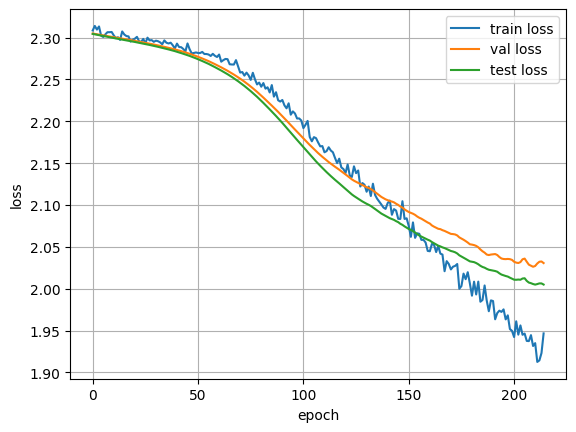

In [14]:
show_loss_through_epochs(arr_losses_train, arr_losses_test, arr_losses_val)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5247024..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.7502832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.558952..1.8112855].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.5332649..1.82].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.44764107..1.7938564].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.24214405..1.6

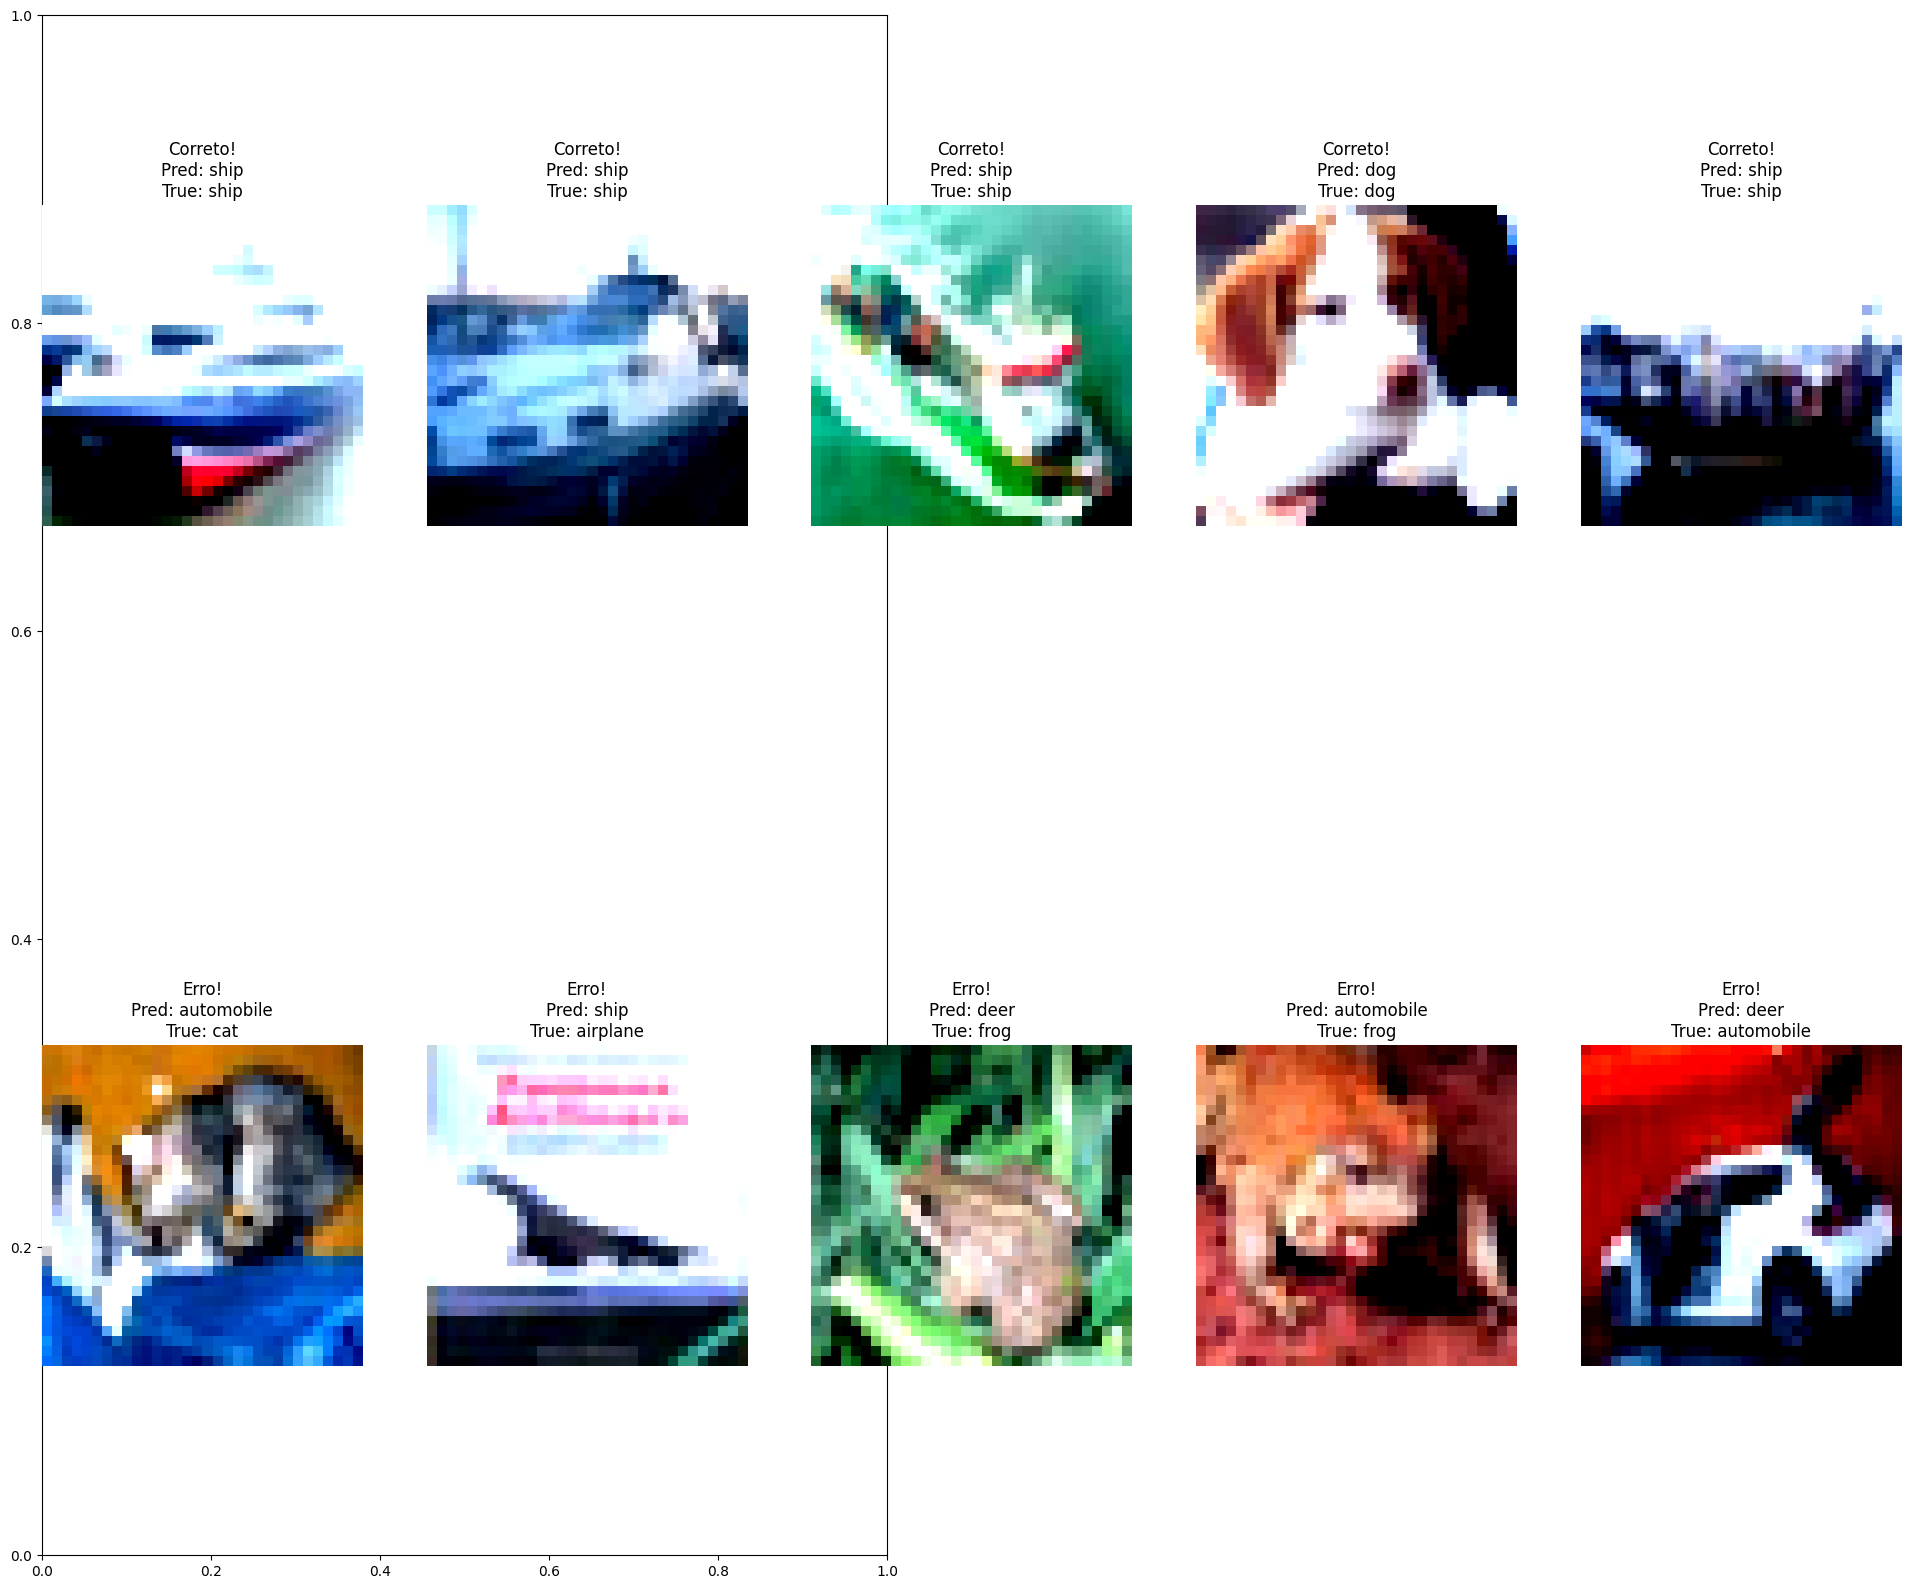

In [15]:
show_predictions(mlp, test_loader, num_samples=5)

In [16]:
mlp.eval()
predictions = []
labels = []

for images, label in test_loader:
  images = images.view(-1,32*32*3).cuda()
  label = label.cuda()

  output = mlp(images)
  _, predicted = torch.max(output,1)

  predictions.extend(predicted.cpu().numpy())
  labels.extend(label.cpu().numpy())

scores = get_scores(labels, predictions)
print(f"Scores of your model\n {scores}\n\n")

Scores of your model
 {'accuracy': 0.21, 'balanced_accuracy': np.float64(0.2188233533300532), 'f1_score': 0.12799800556197644, 'precision': 0.12360969001109298, 'recall': 0.21}




/home/eduardoamorim/Área de trabalho/cin_2025_1/NN/nn-exps/.venvNN/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [17]:
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
           'dog', 'frog', 'horse', 'ship', 'truck'] # .venvNN/lib/python3.12/site-packages/torchvision/prototype/datasets/_builtin/cifar10.categories

labels = np.array(labels)
predictions = np.array(predictions)

stats = {}

print(f"\n shape dataset teste -> {len(test_dataset)}")
print("\n(repr x acc top1) por classe(conjunto teste):")

for i in range(10):
    mask = labels == i
    class_acc = np.mean(predictions[mask] == labels[mask]) * 100
    num_samples = np.sum(mask)
    class_repr = (num_samples / len(labels)) * 100

    stats[classes[i]] = {
        'acuracia': f"{class_acc:.2f}%",
        'num_amostras': num_samples,
        'representatividade': f"{class_repr:.2f}%"
    }

for classe, metricas in stats.items():
    print(f"\n{classe}:")
    print(f"  Acurácia: {metricas['acuracia']}")
    print(f"  Número de amostras: {metricas['num_amostras']}")
    print(f"  Representatividade: {metricas['representatividade']}")


 shape dataset teste -> 1000

(repr x acc top1) por classe(conjunto teste):

airplane:
  Acurácia: 9.71%
  Número de amostras: 103
  Representatividade: 10.30%

automobile:
  Acurácia: 51.69%
  Número de amostras: 89
  Representatividade: 8.90%

bird:
  Acurácia: 0.00%
  Número de amostras: 100
  Representatividade: 10.00%

cat:
  Acurácia: 2.91%
  Número de amostras: 103
  Representatividade: 10.30%

deer:
  Acurácia: 56.67%
  Número de amostras: 90
  Representatividade: 9.00%

dog:
  Acurácia: 18.60%
  Número de amostras: 86
  Representatividade: 8.60%

frog:
  Acurácia: 0.00%
  Número de amostras: 112
  Representatividade: 11.20%

horse:
  Acurácia: 0.00%
  Número de amostras: 102
  Representatividade: 10.20%

ship:
  Acurácia: 79.25%
  Número de amostras: 106
  Representatividade: 10.60%

truck:
  Acurácia: 0.00%
  Número de amostras: 109
  Representatividade: 10.90%
